In [4]:
import math
import pickle as pkl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
import tensorflow as tf
from tensorflow import keras

trainset = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = trainset.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [5]:
fashion_categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
def displayImages(img, label):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(fashion_categories[label])
    plt.axis("off")
    plt.show()

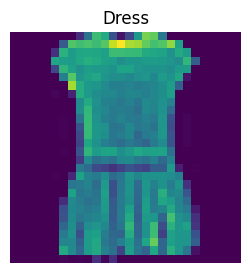

In [6]:
displayImages(x_train[3], y_train[3])

In [7]:
x_train = x_train.reshape(-1, 28, 28, 1)
print(x_train.shape)

(60000, 28, 28, 1)


## Dimension Manipulation

I am changing the shape of my input from (60000, 28,28) to (60000,1,28,28) as PyTorch based GANs accept this format.

In [8]:
x_train =  x_train.astype('float32')
x_train = x_train/255
x_train = x_train*2 - 1

In [9]:
print(x_train.max(),x_train.min())

1.0 -1.0


In [6]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [7]:
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,656 (1.22 MB)

 Trainable params: 318,864 (1.22 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [14]:
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 28, 28, 1)           │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,179 (946.01 KB)

 Trainable params: 242,179 (946.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Avoid memory over-allocation
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
        print("GPU is now active!")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [16]:
!nvidia-smi

Tue Feb 18 16:51:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P0             29W /   70W |     110MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Currently on Epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


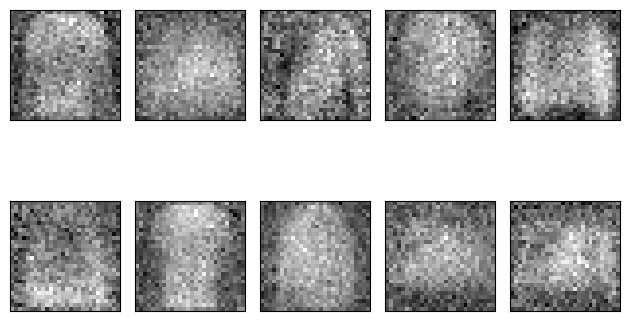

Currently on Epoch 2
Currently on Epoch 3
Currently on Epoch 4
Currently on Epoch 5
Currently on Epoch 6
Currently on Epoch 7
Currently on Epoch 8
Currently on Epoch 9
Currently on Epoch 10
Currently on Epoch 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


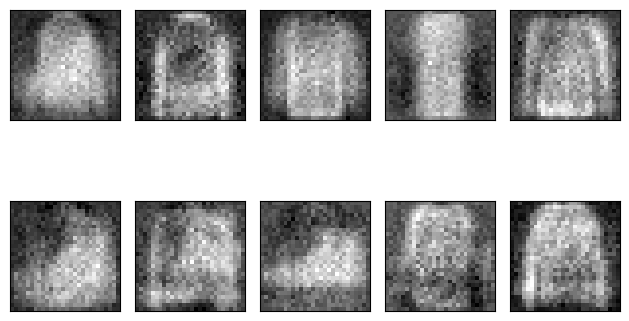

Currently on Epoch 12
Currently on Epoch 13
Currently on Epoch 14
Currently on Epoch 15
Currently on Epoch 16
Currently on Epoch 17
Currently on Epoch 18
Currently on Epoch 19
Currently on Epoch 20
Currently on Epoch 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


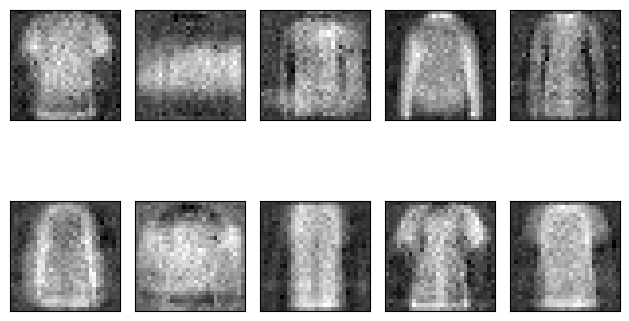

Currently on Epoch 22
Currently on Epoch 23
Currently on Epoch 24
Currently on Epoch 25
Currently on Epoch 26
Currently on Epoch 27
Currently on Epoch 28
Currently on Epoch 29
Currently on Epoch 30
Currently on Epoch 31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


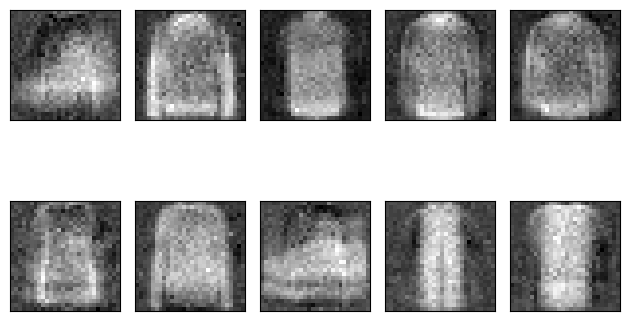

Currently on Epoch 32
Currently on Epoch 33
Currently on Epoch 34
Currently on Epoch 35
Currently on Epoch 36
Currently on Epoch 37
Currently on Epoch 38
Currently on Epoch 39
Currently on Epoch 40
Currently on Epoch 41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


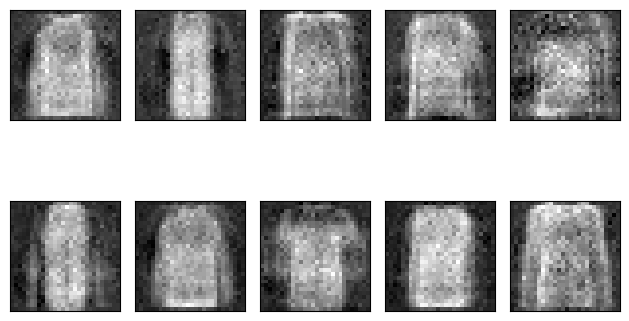

Currently on Epoch 42
Currently on Epoch 43
Currently on Epoch 44
Currently on Epoch 45
Currently on Epoch 46
Currently on Epoch 47
Currently on Epoch 48
Currently on Epoch 49
Currently on Epoch 50


In [17]:
batch_size= 100
vect = 100
with tf.device('/GPU:0'):

 for epoch in range(50):
    print(f"Currently on Epoch {epoch+1}")


    for i in range(x_train.shape[0]//batch_size):
        noise=np.random.normal(size=[batch_size,vect])

        gen_image = generator.predict_on_batch(noise)

        train_dataset = x_train[i*batch_size:(i+1)*batch_size]

        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)

        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)

        noise=np.random.normal(size=[batch_size,vect])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False

        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))
        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

In [8]:
generator.save("generator_model.h5")

# Variational Autoencoders

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Downloading Dataset

In [ ]:
train = torchvision.datasets.MNIST(root='./digitData', train=True, download=True, transform=transforms.ToTensor())
test = torchvision.datasets.MNIST(root='./digitData', train=False, download=True, transform=transforms.ToTensor())
xtrain = train.data.numpy()
ytrain = train.targets.numpy()
x_val = test.data[:1000].numpy()
y_val = test.targets[:1000].numpy()

In [ ]:
counts = np.zeros(10)
idx=[]
for i in range(0,len(ytrain)):
    for j in range(0,10):
        if(ytrain[i]==j):
            counts[j]+=1
            if(counts[j]<=1000):
                idx = np.append(idx,i)


y_train = ytrain[idx.astype('int')]
x_train1 = xtrain[idx.astype('int')]

In [ ]:
## Resizing The Array

In [ ]:
r,_,_ = x_train1.shape
x_train = np.zeros([r,14,14])
for i in range(r):
    a = cv2.resize(x_train1[i].astype('float32'), (14,14))
    x_train[i] = a

xval=x_val
r,_,_ = xval.shape
x_val = np.zeros([r,14,14])
for i in range(r):
    a = cv2.resize(xval[i].astype('float32'), (14,14))
    x_val[i] = a

In [ ]:
## Binarization

In [ ]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(196, 128)
        self.fc21 = nn.Linear(128, 8)
        self.fc22 = nn.Linear(128, 8)

        self.fc3 = nn.Linear(8, 128)
        self.fc4 = nn.Linear(128, 196)

    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def sampling(self, mu, std):
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu))

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5,patience=5, threshold=0.001,
                                                       cooldown=0,min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std):
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, ERR, KLD

In [ ]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 200):

    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0):
            model.eval()
            a, _ = next(iter(testloader))
            a = a.cuda()
            trecon, tmu, tstd = model(a)
            tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
            testl.append(terr/100)
            update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


====> Epoch: 1 Average loss: 30.2004
====> Test set loss: 12.3130
====> Epoch: 2 Average loss: 30.1942
====> Test set loss: 12.3245
====> Epoch: 3 Average loss: 30.1743
====> Test set loss: 12.3806
====> Epoch: 4 Average loss: 30.1614
====> Test set loss: 12.3514
====> Epoch: 5 Average loss: 30.2004
====> Test set loss: 12.3190
====> Epoch: 6 Average loss: 30.1844
====> Test set loss: 12.3630
====> Epoch: 7 Average loss: 30.1669
====> Test set loss: 12.2692
====> Epoch: 8 Average loss: 30.1431
====> Test set loss: 12.3043
====> Epoch: 9 Average loss: 30.1823
====> Test set loss: 12.3039
====> Epoch: 10 Average loss: 30.1791
====> Test set loss: 12.3041
====> Epoch: 11 Average loss: 30.1298
====> Test set loss: 12.2129
====> Epoch: 12 Average loss: 30.1710
====> Test set loss: 12.3354
====> Epoch: 13 Average loss: 30.1805
====> Test set loss: 12.2665
====> Epoch: 14 Average loss: 30.1937
====> Test set loss: 12.2563
====> Epoch: 15 Average loss: 30.1640
====> Test set loss: 12.2796
====

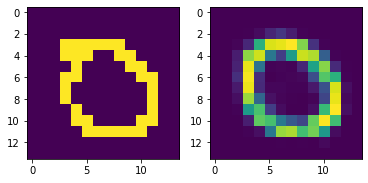

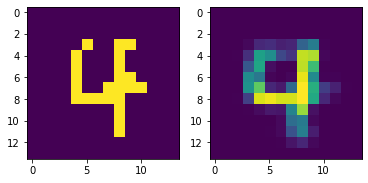

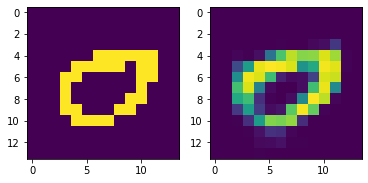

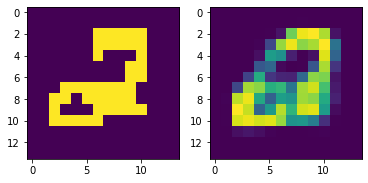

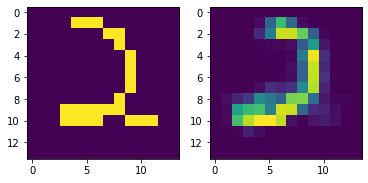

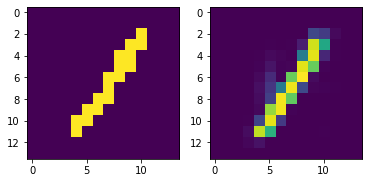

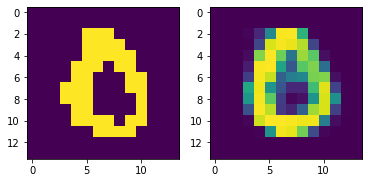

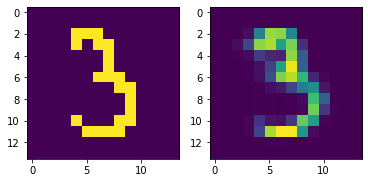

In [ ]:
model.eval()
for i in range(8):
    a,t = next(iter(trainloader))
    a = a.cuda()
    recon, mu, std = model(a[0])
    b = recon[0].reshape((14,14))
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(a[0].detach().cpu().numpy())
    axarr[1].imshow(b.detach().cpu().numpy())

In [9]:
model.save("VAE_DIG.h5")

In [ ]:
trainset = datasets.FashionMNIST(root='./fashionData', train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))
testset = datasets.FashionMNIST(root='./fashionData', train=False, download=True,
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))

In [ ]:
print(len(trainset))

60000


In [ ]:
print(np.unique(trainset.targets))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
x_train = trainset.data.numpy()
y_train = trainset.targets.numpy()
x_val = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

In [ ]:
fashion_categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
def displayImages(img, label):
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(fashion_categories[label])
    plt.axis("off")
    plt.show()

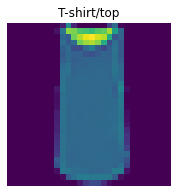

In [ ]:
displayImages(xtrain[2], ytrain[2])

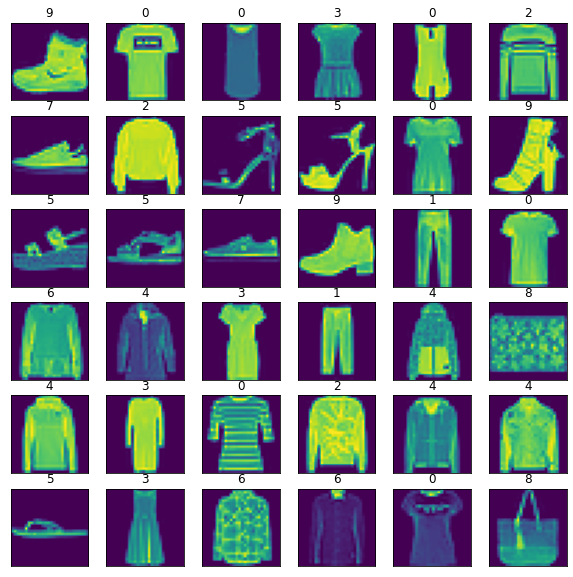

In [ ]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names = list(range(10))
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(xtrain[i].reshape((28,28)))
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

In [ ]:
counts = np.zeros(10)
idx=[]
for i in range(0,len(ytrain)):
    for j in range(0,10):
        if(ytrain[i]==j):
            counts[j]+=1
            if(counts[j]<=4000):
                idx = np.append(idx,i)


y_train = ytrain[idx.astype('int')]
x_train1 = xtrain[idx.astype('int')]

In [ ]:
x_train = (x_train1 > 128).astype(np.float32)
x_val = (x_val > 128).astype(np.float32)

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc21 = nn.Linear(128, 8)
        self.fc22 = nn.Linear(128, 8)

        self.fc3 = nn.Linear(8, 128)
        self.fc4 = nn.Linear(128, 784)

    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def sampling(self, mu, std):
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu))

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5,patience=5, threshold=0.001,
                                                       cooldown=0,min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std):
    ERR = F.binary_cross_entropy(y, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, ERR, KLD

In [ ]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 200):

    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0):
            model.eval()
            a, _ = next(iter(testloader))
            a = a.cuda()
            trecon, tmu, tstd = model(a)
            tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
            testl.append(terr/100)
            update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


====> Epoch: 1 Average loss: 216.5557
====> Test set loss: 216.0247
====> Epoch: 2 Average loss: 202.0872
====> Test set loss: 188.9856
====> Epoch: 3 Average loss: 194.1504
====> Test set loss: 201.6784
====> Epoch: 4 Average loss: 195.0265
====> Test set loss: 187.3576
====> Epoch: 5 Average loss: 200.8951
====> Test set loss: 188.4962
====> Epoch: 6 Average loss: 201.5495
====> Test set loss: 198.9232
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
====> Epoch: 7 Average loss: 199.7331
====> Test set loss: 206.4936
====> Epoch: 8 Average loss: 182.7548
====> Test set loss: 180.9977
====> Epoch: 9 Average loss: 189.1767
====> Test set loss: 187.6885
====> Epoch: 10 Average loss: 186.2321
====> Test set loss: 186.1053
====> Epoch: 11 Average loss: 187.9441
====> Test set loss: 180.6809
====> Epoch: 12 Average loss: 179.2572
====> Test set loss: 175.6331
Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
====> Epoch: 13 Average loss: 181.3107
====> Test set los

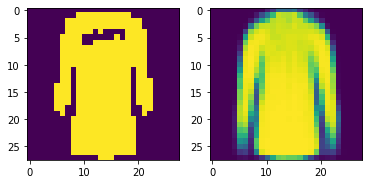

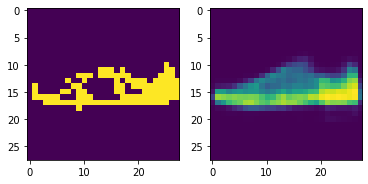

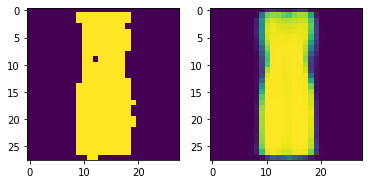

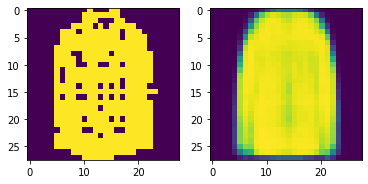

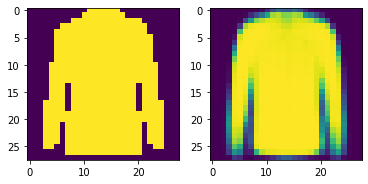

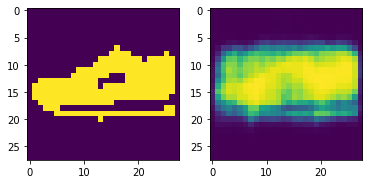

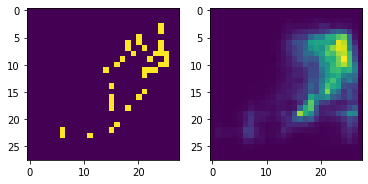

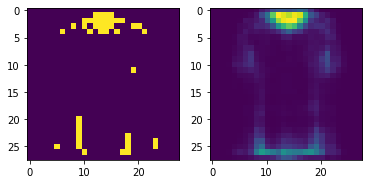

In [ ]:
model.eval()
for i in range(8):
    a,t = next(iter(trainloader))
    a = a.cuda()
    recon, mu, std = model(a[0])
    b = recon[0].reshape((28,28))
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(a[0].detach().cpu().numpy())
    axarr[1].imshow(b.detach().cpu().numpy())

In [10]:
model.save("VAE_Fash.h5")

In [ ]:
## Question 5